In [1]:
from pathlib import Path

import numpy as np
from astropy.io import fits

# Define where the directory is located
datadir2 = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Live"
datadir = "C:/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope"
procdir = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Process/i"

# Use pathlib.Path to create a pathobject
pathobject = Path(datadir)
pathobject2 = Path(datadir2)

myfitsfiles = []
myfitsfiles2 = []

# Loop over all files in the directory and grab the fits files
for f in pathobject.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles.append(f)
        
for f in pathobject2.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles2.append(f)

# Print first 10 fitsfiles to check if we got everything correct        
for i in range(10):
    print(myfitsfiles[i])

C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000001.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000002.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000003.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000004.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000005.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000006.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000007.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000008.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000009.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000010.BIAS.FIT


In [2]:
# Create the image class

class image:
    def __init__(self, filepath, fits_imagetyp='', fits_exptime=0, fits_filter='', fits_date_obs=0, fits_naxis1=0, fits_naxis2=0, pixelsize=18):
        self.filepath = filepath
        self.filename = filepath.name
        self.imagetyp = fits_imagetyp
        self.exptime = fits_exptime
        self.filter = fits_filter
        self.date_obs = fits_date_obs
        self.naxis1 = fits_naxis1
        self.naxis2 = fits_naxis2
        self.pixelsize = pixelsize

myimages = []
myimages2 = []

# Loop over all of the filepaths in myfitsfiles, open each image, give it the image class and append it to the list of images
for filepath in myfitsfiles:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ')) 
    myimages.append(newimage)
    hdulist.close()

for filepath in myfitsfiles2:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ'))
    myimages2.append(newimage)
    hdulist.close()    

# Comment for self: Dark Frame, Bias Frame, Flat Field, Light Frame

436.0 12912.0 449.2079908297178


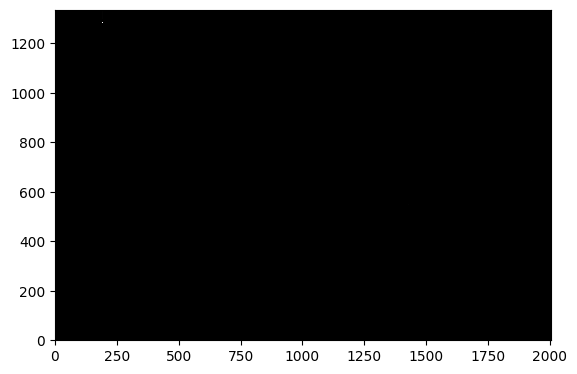

In [3]:
# Create the masterbias

from matplotlib.pyplot import figure, show, close
from astropy.visualization import ImageNormalize, SquaredStretch

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Bias_list = []
count = 0
for im in myimages:
    if 'bias frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Bias_list.append(dat)
        hdulist.close

# Then we median combine the images        
Bias_stack = np.stack(Bias_list)
masterbias = np.median(Bias_stack, axis=0)

# These look pretty good, just weird it doesn't show up on the plot
print(masterbias.min(), masterbias.max(), masterbias.mean())

# Show the resulting masterbias
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterbias, interpolation='none', origin='lower', cmap='gray')
show(fig)
close(fig)

-0.8833333333333333 58.656666666666666 0.0015189325689937494


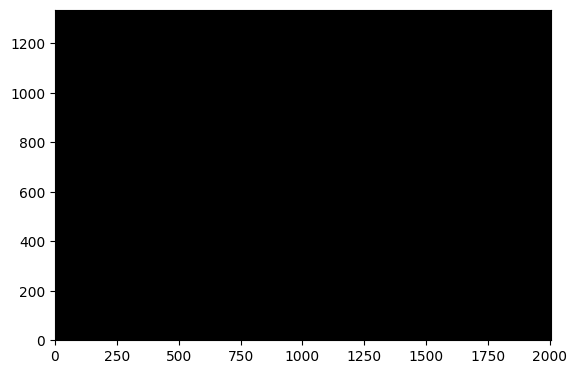

In [4]:
# Create the masterdark

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Darks_list = []
count = 0
for im in myimages:
    if 'dark frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Darks_list.append((dat - masterbias)/im.exptime)
        hdulist.close

# Then we median combine the darks
Darks_stack = np.stack(Darks_list)
masterdark = np.median(Darks_stack, axis=0)

# The min, max and mean look pretty good, just weird it doesn't show up on the plot
print(masterdark.min(), masterdark.max(), masterdark.mean())

# Show the resulting masterdark
fig = figure()
frame = fig.add_subplot(1,1,1)
norm = ImageNormalize(vmin=5, vmax=100, stretch=SquaredStretch())
frame.imshow(masterdark, interpolation='none', origin='lower', cmap='gray', norm=norm)
show(fig)
close(fig)


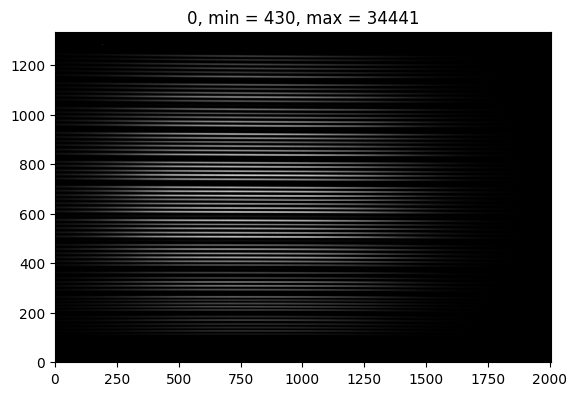

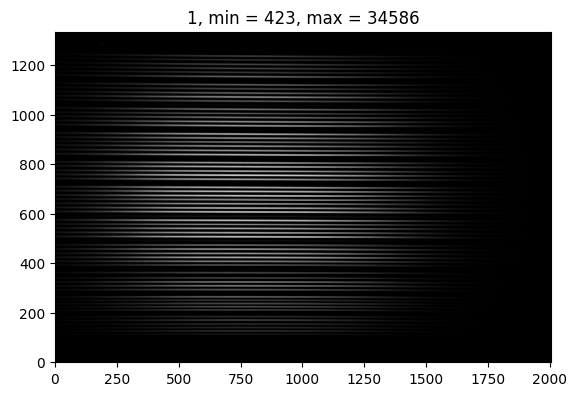

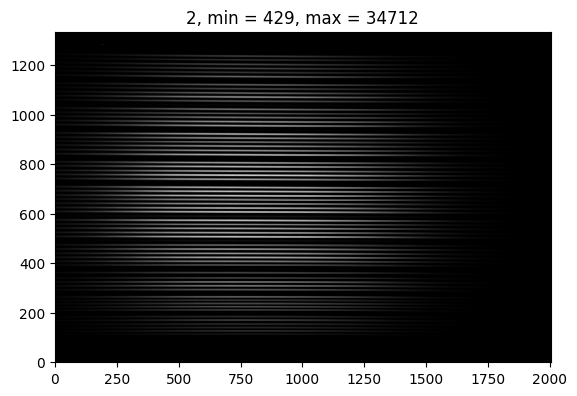

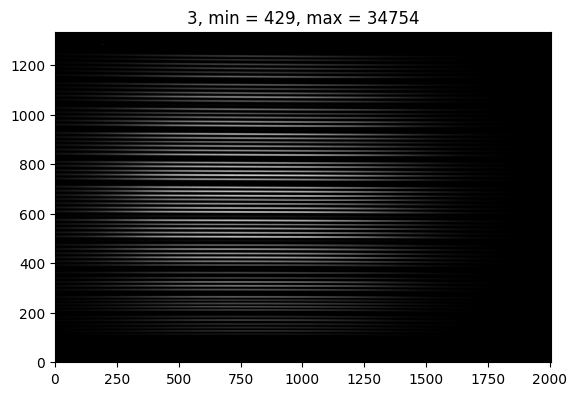

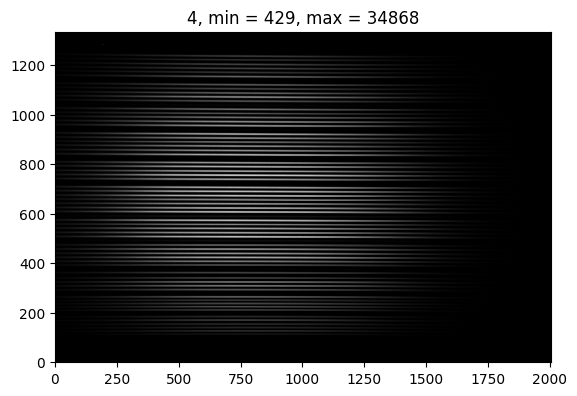

In [5]:
# Let's do the masterflat next

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Flats_list = []
count = 0
for im in myimages2:
    if 'flat field' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Flats_list.append(dat)
        hdulist.close

# Lets inspect the Flats
c = 0
for obj in Flats_list:
    fig = figure()
    frame = fig.add_subplot(1,1,1)
    norm = ImageNormalize(stretch=SquaredStretch())
    frame.imshow(obj, interpolation='none', origin='lower', cmap='gray', norm=norm)
    frame.set_title(f"{c}, min = {np.min(obj)}, max = {np.max(obj)}")
    show(fig)
    close(fig)
    c += 1

# We see that the first 5 show a proper flat
Flats_list_sorted = Flats_list[0:4]

-0.18505599412520654 12.554433633192582 2.132502782066041


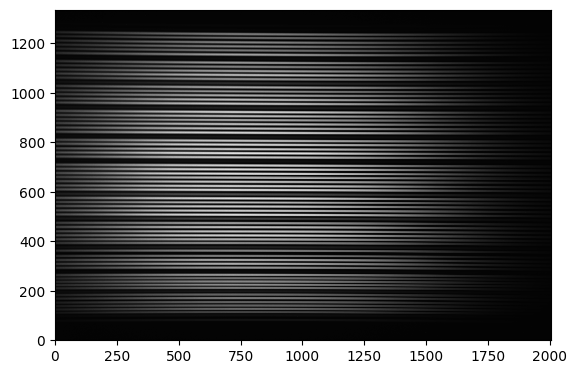

In [6]:
# Then we calibrate the flats with masterbias and median combine the images (We don't need to concern with the darks as the dark current can't really build up during flats
Flats_stack = np.stack(Flats_list_sorted-masterbias)
Flats_median = np.median(Flats_stack)
Flats_stack_normalized = Flats_stack/Flats_median
masterflat_to_be_normalized = np.median(Flats_stack_normalized, axis=0)
masterflat = masterflat_to_be_normalized/np.median(masterflat_to_be_normalized)

print(masterflat.min(), masterflat.max(), masterflat.mean())

# Show the resulting masterflat
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterflat, interpolation='none', origin='lower', cmap='gray')
show(fig)
close(fig)

In [7]:
# Now that we have our master calibration files we can work on our lights, first we calibrate
lights = []
for im in myimages2:
    if 'light frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        data = hdulist[0].data.astype(float)
        data -= masterdark*im.exptime + masterbias
        # data /= masterflat
        lights.append(data)
        hdulist.close
        
# Let's inspect the lights
# c = 0
# for obj in lights:
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.imshow(obj, interpolation='none', origin='lower', cmap='gray')
#     frame.set_title(f"light {c} with min: {obj.min()}, max: {obj.max()}")
#     show(fig)
#     close(fig)
#     c += 1

-7071.5 7407.0 81.3293796015753


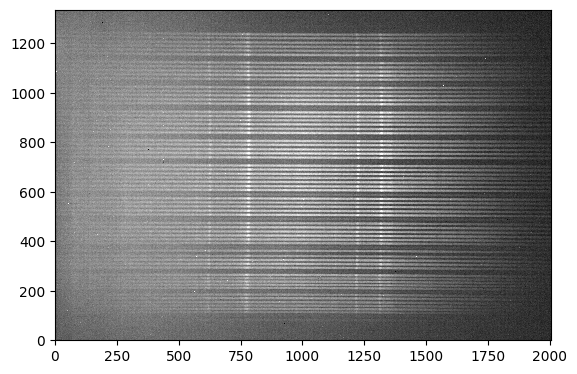

In [65]:
# We use just the first 5, since they appear to be of the same target
# 32-42 excluding 35
lights_sorted_galaxy = lights[32:34]+lights[36:42]
lights_sorted_vega = lights[43:48]
lights_sorted_moon = lights[-5:-1]
lights_calibration = lights[21:25]
lights_sorted_arcturus = lights[29:31]
lights_stack = np.stack(lights_sorted_galaxy)
masterlight = np.median(lights_stack, axis=0)

lights_stack_moon = np.stack(lights_sorted_moon)
masterlight_moon = np.median(lights_stack_moon, axis=0)

# The min, max and mean look pretty good, just weird it doesn't show up on the plot
print(masterlight.min(), masterlight.max(), masterlight.mean())

# Show the resulting masterlight
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterlight, interpolation='none', origin='lower', cmap='gray', vmin=0, vmax=180)
show(fig)
close(fig)

In [9]:
# Now that we have a program which calibrates the images we can start on figuring out where the spectral lines are. This is easiest done by using the flat frames first slice in a vertical line

vert_slice = masterflat[:,1000]
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(vert_slice)
# frame.axis([600, 700, 8, 10])
# show(fig)
# close(fig)

# Based on the plot we want to exclude values with less then 10000 counts
fibre_locations = np.where(vert_slice>3)[0]

# Now we would like to group all of the values in a single fibre into a single median value to reduce noise, although we do clearly see that the values on the outside are significantly less then the ones in the center.
fibre_locations_dict = {}
i = 1
n = "fibre_0"
c = 0

# Exclude outer 2, because poor signal to noise ratio 
# And add weighting, cause these tops be looking hella mid

for obj in fibre_locations:
    try:
        if obj+1 == fibre_locations[i]:
            try:
                fibre_locations_dict[n].append(obj)
            except:
                fibre_locations_dict[n] = []
                fibre_locations_dict[n].append(obj)
        else:
            fibre_locations_dict[n].append(obj)
            c+=1
            n = f'fibre_{c}'        
        i+=1
    
    except:
        fibre_locations_dict[n].append(obj)
print(fibre_locations_dict)

{'fibre_0': [110, 111, 112, 113], 'fibre_1': [122, 123, 124, 125, 126, 127, 128, 129], 'fibre_2': [135, 136, 137, 138, 139, 140, 141, 142], 'fibre_3': [149, 150, 151, 152, 153, 154, 155, 156], 'fibre_4': [164, 165, 166, 167, 168, 169, 170, 171, 172], 'fibre_5': [179, 180, 181, 182, 183, 184, 185, 186], 'fibre_6': [205, 206, 207, 208, 209, 210, 211, 212, 213], 'fibre_7': [218, 219, 220, 221, 222, 223, 224, 225, 226], 'fibre_8': [231, 232, 233, 234, 235, 236, 237, 238, 239, 240], 'fibre_9': [245, 246, 247, 248, 249, 250, 251, 252], 'fibre_10': [258, 259, 260, 261, 262, 263, 264, 265, 266], 'fibre_11': [287, 288, 289, 290, 291, 292, 293, 294, 295], 'fibre_12': [302, 303, 304, 305, 306, 307, 308, 309, 310, 311], 'fibre_13': [317, 318, 319, 320, 321, 322, 323, 324, 325, 326], 'fibre_14': [335, 336, 337, 338, 339, 340, 341, 342], 'fibre_15': [356, 357, 358, 359, 360, 361, 362, 363, 364], 'fibre_16': [386, 387, 388, 389, 390, 391, 392, 393, 394], 'fibre_17': [400, 401, 402, 403, 404, 405, 406

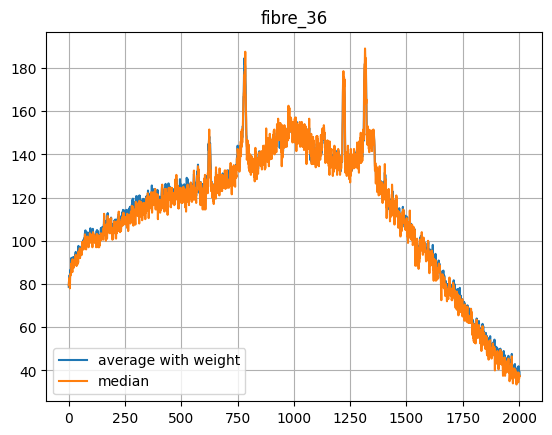

In [66]:
# Now that we have the locations of the fibres we make an intensity plot of the median of all the collumns that a fibre consists of.
def find_maximum_slice(horizontal_slice_dict):
    '''
    :purpose: Finds the location of the slice which contains the maximum value
    :input: Dictionary medians of horizontal slices
    :return: The location of the slice which contains the maximum value
    '''
    Total_max = np.max(horizontal_slice_dict['fibre_0'])
    for i in horizontal_slice_dict:
        Max_of_row = np.max(horizontal_slice_dict[i])
        if Max_of_row>Total_max:
            Total_max = Max_of_row
            location = i
    return location

horizontal_slice_dict = {}
horizontal_slice_moon_dict = {}
horizontal_slice_dict_average = {}
flat_horizontal_slice_dict = {}
flat_horizontal_slice_dict_average = {}
horizontal_slice_list = []

# Loop over all the fibres
for i in fibre_locations_dict:
    # Do the slicing
    horizontal_slice = masterlight[fibre_locations_dict[i],:]
    flat_horizontal_slice = masterflat[fibre_locations_dict[i], :]
    # Take the median
    horizontal_slices_median = np.median(horizontal_slice, axis=0)
    flat_horizontal_slice_median = np.median(flat_horizontal_slice, axis=0)
    # Try adding weighting to the different pixels in an attempt to reduce the noise
    horizontal_slices_mean = np.average(horizontal_slice, axis=0, weights = flat_horizontal_slice)
    flat_horizontal_slice_mean = np.average(flat_horizontal_slice, axis=0, weights = flat_horizontal_slice)
    # Add this median line to the dictionary
    horizontal_slice_dict[i] = horizontal_slices_median
    horizontal_slice_dict_average[i] = horizontal_slices_mean
    flat_horizontal_slice_dict[i] = flat_horizontal_slice_median
    flat_horizontal_slice_dict_average[i] = flat_horizontal_slice_mean
    # Append list
    horizontal_slice_list.append(horizontal_slices_median)
    

# We want to save the horizontal_slice_dict and use it in further stuff
location_of_maximum = find_maximum_slice(horizontal_slice_dict)
# location_of_maximum = ("fibre_40")

# Plot fibre with max intensity
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(horizontal_slice_dict_average[location_of_maximum], label = 'average with weight')
frame.plot(horizontal_slice_dict[location_of_maximum], label = 'median')
frame.set_title(location_of_maximum)
frame.legend()
frame.grid()
show(fig)
close(fig)


# for obj in fibre_locations_dict.keys():
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.plot(horizontal_slice_dict[obj])
#     frame.set_title(obj)
#     frame.grid()
#     show(fig)
#     close(fig)

# horizontal_slice_list_sorted = horizontal_slice_list[27:31:1]
# median_slices = np.median(horizontal_slice_list_sorted, axis=0)

# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(median_slices)
# frame.set_title("median of main fibres")
# frame.grid()
# show(fig)
# close(fig)

In [64]:
# Shift calculation based on the biggest spike in the calibration data!

def find_maximum_in_slices(average_dict):
    Maximums = {}
    Maximums_list = []
    for i in average_dict.keys():
        Maximum = np.where(average_dict[i]==np.max(average_dict[i]))[0][0]
        Maximums[i] = Maximum
        Maximums_list.append(Maximum)
    centre = np.median(Maximums_list)    
    return(Maximums, centre)

def calculate_shifts(average_dict, align_pixel, centre):
    shifts = {}
    for i in average_dict.keys():
        shifts[i] = centre - align_pixel[i]
    return shifts

align_pixel, centre = find_maximum_in_slices(horizontal_slice_dict_average)
shifts = calculate_shifts(horizontal_slice_dict_average, align_pixel, centre)

{'fibre_0': 8.0, 'fibre_1': 4.0, 'fibre_2': 5.0, 'fibre_3': 5.0, 'fibre_4': 7.0, 'fibre_5': 6.0, 'fibre_6': 5.0, 'fibre_7': 4.0, 'fibre_8': 4.0, 'fibre_9': 5.0, 'fibre_10': 5.0, 'fibre_11': 3.0, 'fibre_12': 2.0, 'fibre_13': 2.0, 'fibre_14': 1.0, 'fibre_15': 2.0, 'fibre_16': 1.0, 'fibre_17': 0.0, 'fibre_18': 0.0, 'fibre_19': 1.0, 'fibre_20': 0.0, 'fibre_21': 0.0, 'fibre_22': 0.0, 'fibre_23': -1.0, 'fibre_24': 0.0, 'fibre_25': 0.0, 'fibre_26': -1.0, 'fibre_27': 1.0, 'fibre_28': -1.0, 'fibre_29': 0.0, 'fibre_30': -2.0, 'fibre_31': -2.0, 'fibre_32': -1.0, 'fibre_33': -5.0, 'fibre_34': -3.0, 'fibre_35': -2.0, 'fibre_36': -2.0, 'fibre_37': -1.0, 'fibre_38': -2.0, 'fibre_39': -2.0, 'fibre_40': -1.0, 'fibre_41': -1.0, 'fibre_42': -1.0, 'fibre_43': -2.0, 'fibre_44': -2.0, 'fibre_45': 0.0, 'fibre_46': -2.0, 'fibre_47': -1.0, 'fibre_48': -1.0, 'fibre_49': 0.0, 'fibre_50': -1.0, 'fibre_51': 0.0, 'fibre_52': -1.0, 'fibre_53': 0.0, 'fibre_54': 0.0, 'fibre_55': 1.0, 'fibre_56': 1.0, 'fibre_57': 1.0, 

C:\Users\stefa\AppData\Local\Temp\ipykernel_22080\2017687849.py:25: RuntimeWarning: invalid value encountered in divide
  background_subtracted[i] = aligned_average_dict[i] / background
C:\Users\stefa\AppData\Local\Temp\ipykernel_22080\2017687849.py:25: RuntimeWarning: divide by zero encountered in divide
  background_subtracted[i] = aligned_average_dict[i] / background


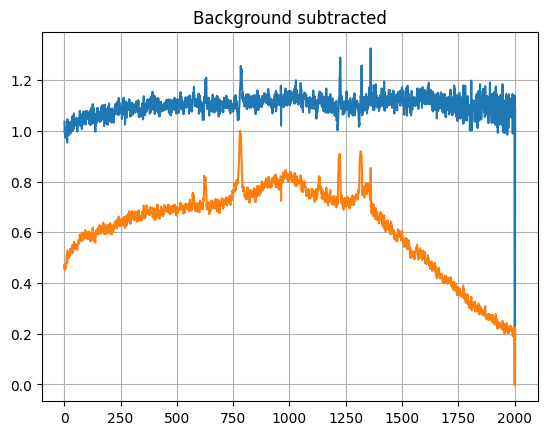

In [82]:
def align_spectra(average_dict, shifts):
    aligned_average_dict = {}
    for i in average_dict.keys():
        if shifts[i] > 0:
            shift = int(shifts[i])
            aligned_average_dict[i] = average_dict[i][shift::]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],0,np.zeros(shift))
        if shifts[i] < 0:
            shift = int(abs(shifts[i]))
            aligned_average_dict[i] = average_dict[i][:-shift:]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],-1,np.zeros(shift))
    return aligned_average_dict

def get_background(aligned_average_dict):
    aligned_average_list = []
    for i in aligned_average_dict.keys():
        aligned_average_list.append(aligned_average_dict[i])
    aligned_stack = np.stack(aligned_average_list)
    aligned_median = np.median(aligned_stack, axis=0)
    return aligned_median

def background_subtraction(aligned_average_dict,background):
    background_subtracted = {}
    for i in aligned_average_dict.keys():
        background_subtracted[i] = aligned_average_dict[i] / background
    return background_subtracted

aligned_average_dict = align_spectra(horizontal_slice_dict_average, shifts)
background = get_background(aligned_average_dict)
background_subtracted = background_subtraction(aligned_average_dict,background)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(background_subtracted['fibre_35'])
frame.plot(aligned_average_dict['fibre_35']/aligned_average_dict['fibre_35'].max())
frame.set_title("Background subtracted")
frame.grid()
show(fig)
close(fig)

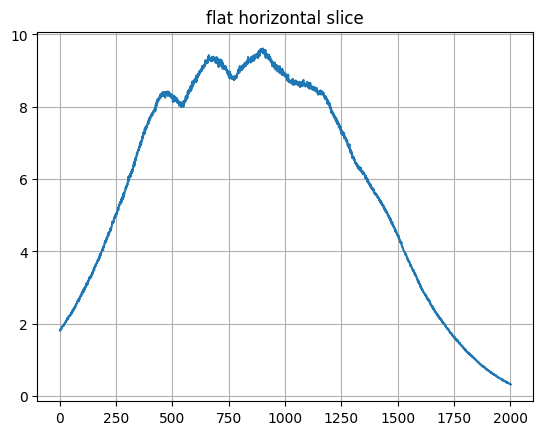

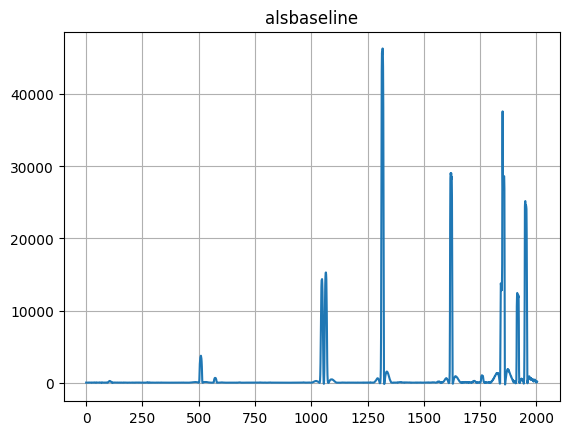

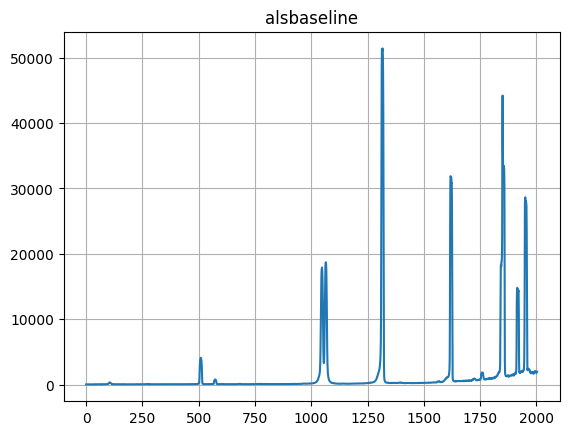

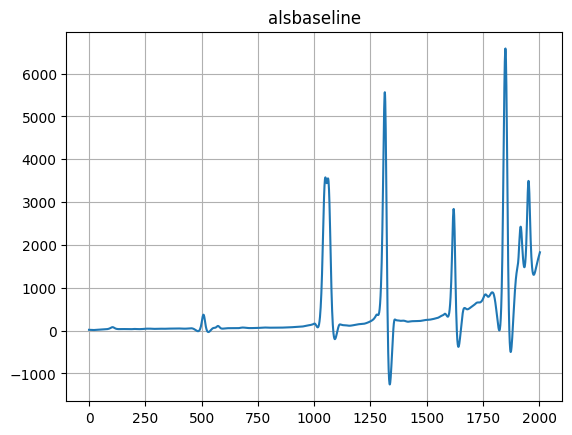

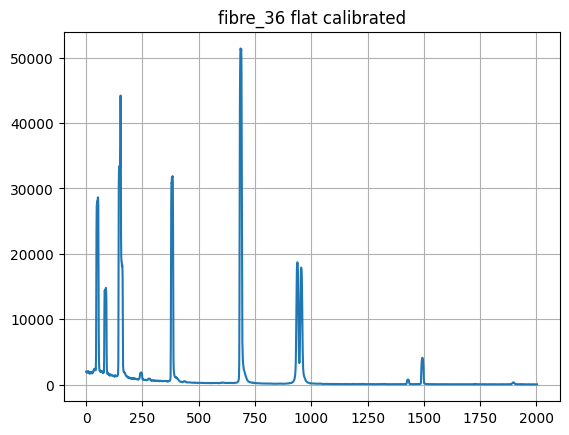

In [12]:
import spectrapepper
import specreduce
from specreduce.calibration_data import load_onedstds



fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(flat_horizontal_slice_dict[location_of_maximum])
frame.set_title("flat horizontal slice")
frame.grid()
show(fig)
close(fig)

flat_calibrated = horizontal_slice_dict[location_of_maximum]/(flat_horizontal_slice_dict[location_of_maximum]/np.median(flat_horizontal_slice_dict[location_of_maximum]))

# Baseline is basically noise reduction for the spectroscope (Not sure if worth)
baseline = spectrapepper.alsbaseline(flat_calibrated, lam=10)
smoothest_baseline = flat_calibrated - spectrapepper.alsbaseline(flat_calibrated, lam=100000)
baseline_subtracted = flat_calibrated - baseline
continuum_removed = flat_calibrated / baseline_subtracted

# Same thing but now do it for weighted average
flat_calibrated_average = horizontal_slice_dict_average[location_of_maximum]/(flat_horizontal_slice_dict_average[location_of_maximum]/np.median(flat_horizontal_slice_dict_average[location_of_maximum]))
baseline_average = spectrapepper.alsbaseline(flat_calibrated_average, lam=10)
smoothest_baseline_average = flat_calibrated_average - spectrapepper.alsbaseline(flat_calibrated_average, lam=100000)
baseline_subtracted_average = flat_calibrated_average - baseline_average
continuum_removed_average = flat_calibrated_average / baseline_subtracted_average

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(baseline)
frame.set_title("alsbaseline")
frame.grid()
show(fig)
close(fig)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(flat_calibrated)
frame.set_title("alsbaseline")
frame.grid()
show(fig)
close(fig)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(baseline_subtracted)
frame.set_title("alsbaseline")
frame.grid()
show(fig)
close(fig)

# flat_calibrated = horizontal_slice_dict['fibre_27']/(horizontal_slice_moon_dict['fibre_27']/np.median(horizontal_slice_moon_dict['fibre_27']))

flat_calibrated = flat_calibrated[-1::-1]   # Flip

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(flat_calibrated)
frame.set_title(f"{location_of_maximum} flat calibrated")
frame.grid()
show(fig)
close(fig)


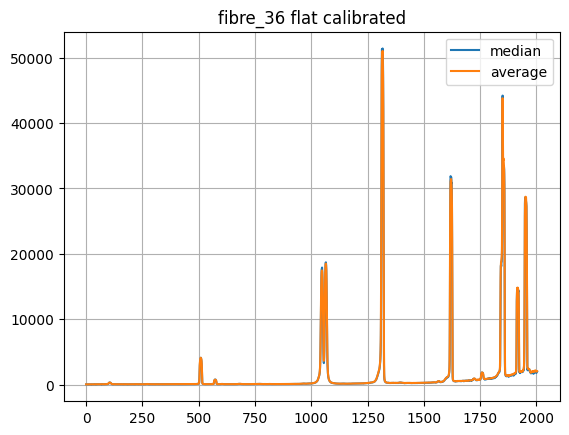

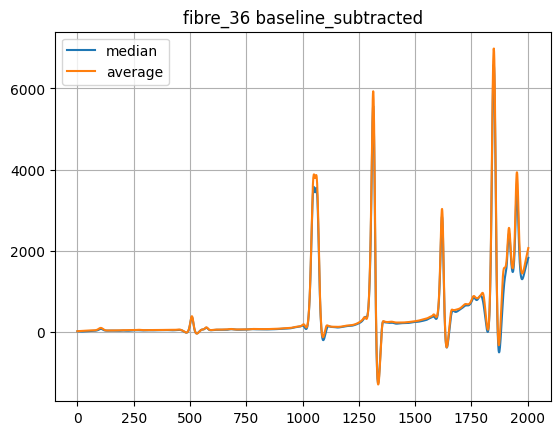

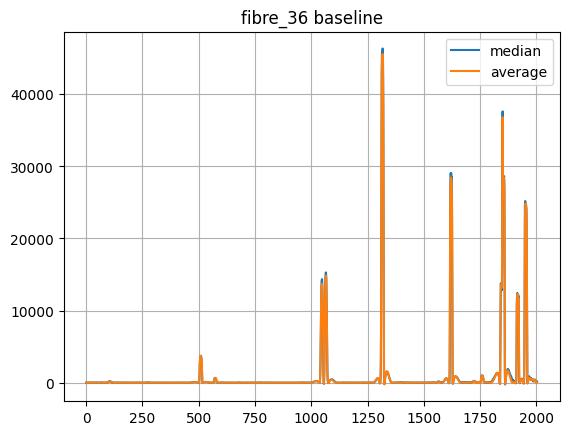

In [13]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(flat_calibrated[::-1], label = 'median')
frame.plot(flat_calibrated_average, label = 'average')
frame.set_title(f"{location_of_maximum} flat calibrated")
frame.grid()
frame.legend()
show(fig)
close(fig)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(baseline_subtracted, label = 'median')
frame.plot(baseline_subtracted_average, label = 'average')
frame.set_title(f"{location_of_maximum} baseline_subtracted")
frame.grid()
frame.legend()
show(fig)
close(fig)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(baseline, label = 'median')
frame.plot(baseline_average, label = 'average')
frame.set_title(f"{location_of_maximum} baseline")
frame.grid()
frame.legend()
show(fig)
close(fig)

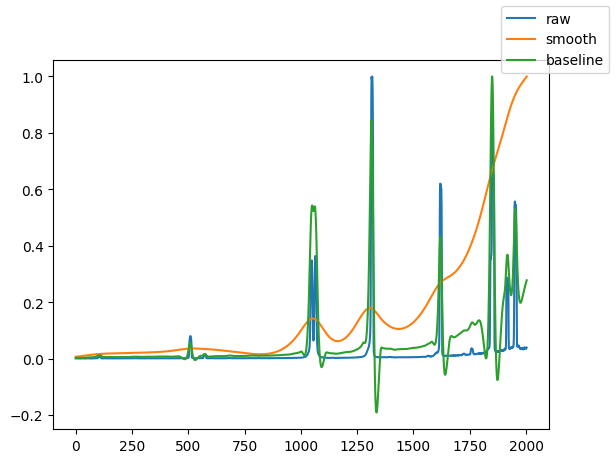

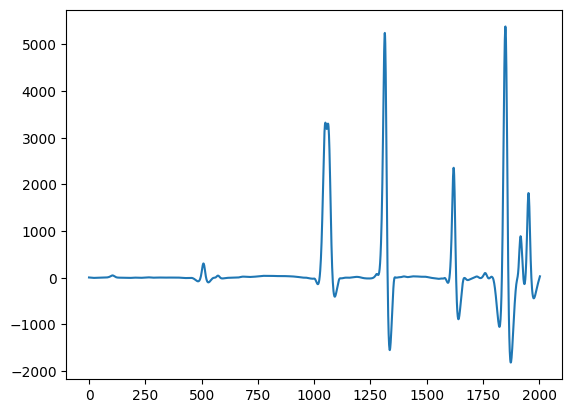

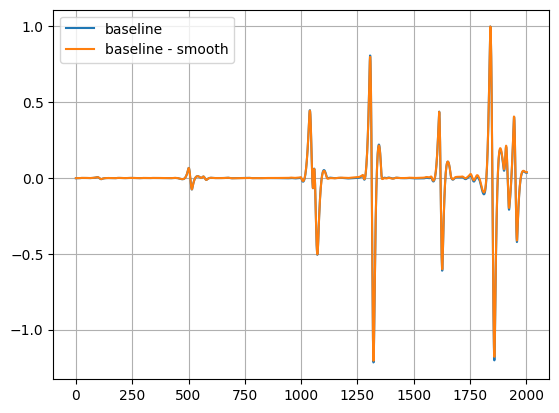

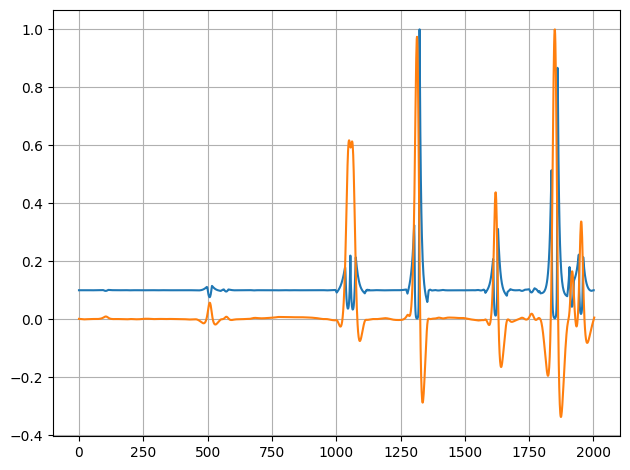

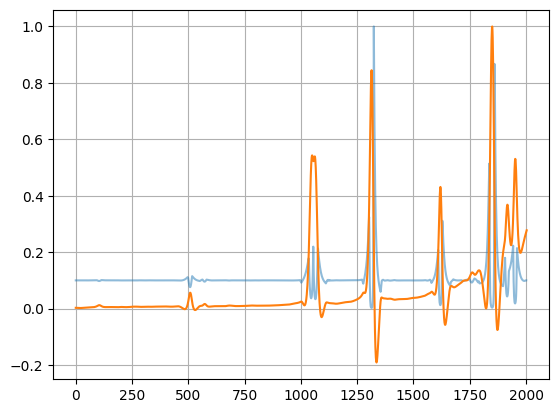

In [14]:
from matplotlib.pyplot import subplots

# baseline_subtracted, smoothest_baseline = -baseline_subtracted, -smoothest_baseline

fig, ax = subplots()
ax.plot(flat_calibrated[::-1]/flat_calibrated.max(), label="raw")
ax.plot(smoothest_baseline/smoothest_baseline.max(), label="smooth")
ax.plot(baseline_subtracted/baseline_subtracted.max(), label="baseline")
fig.legend()
show()
close(fig)


dat2 = baseline_subtracted
data_var = baseline_subtracted - smoothest_baseline

fig, ax = subplots()
ax.plot(data_var)
show()
close(fig)

deriv = []
der2 = []
for i in range(data_var.size-1):
    d = data_var[i+1]-data_var[i]
    d2 = dat2[i+1]-dat2[i]
    deriv.append(d)
    der2.append(d2)
deriv = np.array(deriv)/np.max(deriv)
der2 = np.array(der2)/np.max(der2)
fig, ax = subplots(1, 1)
ax.plot(((deriv)), label="baseline")
ax.plot(der2, label="baseline - smooth")
ax.grid()
ax.legend(loc='best')
show()
close(fig)

data_var = deriv
deriv = []

for i in range(data_var.size-1):
    d = data_var[i+1]-data_var[i]
    deriv.append(d)
deriv = np.array(deriv)/np.max(deriv)
fig, ax = subplots()
fin = 10**((deriv))
ax.plot(fin/fin.max())
fin_base = baseline_subtracted - smoothest_baseline 
ax.plot(fin_base/fin_base.max())
ax.grid()
fig.set_tight_layout(True)
show()
close(fig)


fig, ax = subplots()
ax.plot(fin/fin.max(), label="peaks", alpha=0.5)
ax.plot(baseline_subtracted/baseline_subtracted.max(), label="baseline")
ax.grid()
show()
close(fig)
# Timo code

In [15]:
# from matplotlib.pyplot import subplots
# 
# # baseline_subtracted, smoothest_baseline = -baseline_subtracted, -smoothest_baseline
# 
# fig, ax = subplots()
# ax.plot(flat_calibrated_average/flat_calibrated_average.max(), label="raw")
# ax.plot(smoothest_baseline_average/smoothest_baseline_average.max(), label="smooth")
# ax.plot(baseline_subtracted_average/baseline_subtracted_average.max(), label="baseline")
# fig.legend()
# show()
# close(fig)
# 
# 
# dat2_average = baseline_subtracted_average
# data_var_average = baseline_subtracted_average - smoothest_baseline_average
# 
# fig, ax = subplots()
# ax.plot(data_var_average)
# show()
# close(fig)
# 
# deriv_average = []
# der2_average = []
# for i in range(data_var_average.size-1):
#     d_average = data_var_average[i+1]-data_var_average[i]
#     d2_average = dat2_average[i+1]-dat2_average[i]
#     deriv_average.append(d_average)
#     der2_average.append(d2_average)
# deriv_average = np.array(deriv_average)/np.max(deriv_average)
# der2_average = np.array(der2_average)/np.max(der2_average)
# fig, ax = subplots(1, 1)
# ax.plot(((deriv_average)), label="baseline")
# ax.plot(der2_average, label="baseline - smooth")
# ax.grid()
# ax.legend(loc='best')
# show()
# close(fig)
# 
# data_var_average = deriv_average
# deriv_average = []
# 
# for i in range(data_var_average.size-1):
#     d_average = data_var_average[i+1]-data_var_average[i]
#     deriv_average.append(d_average)
# deriv_average = np.array(deriv_average)/np.max(deriv_average)
# 
# fig, ax = subplots()
# fin_average = 10**((deriv_average))
# ax.plot(fin_average/fin_average.max())
# fin_base_average = baseline_subtracted_average - smoothest_baseline_average
# ax.plot(fin_base_average/fin_base_average.max())
# ax.grid()
# fig.set_tight_layout(True)
# show()
# close(fig)
# 
# 
# fig, ax = subplots()
# ax.plot(fin_average/fin_average.max(), label="peaks", alpha=0.5)
# ax.plot(baseline_subtracted_average/baseline_subtracted_average.max(), label="baseline")
# ax.plot(flat_calibrated_average/flat_calibrated_average.max(), label="raw")
# ax.grid()
# show()
# close(fig)
# # Timo code 2

In [16]:
# # %matplotlib
# fig, ax = subplots()
# ax.plot(fin/fin.max(), label="peaks", alpha=0.5)
# ax.plot(fin_average/fin_average.max(), label="average peaks", alpha = 0.5)
# ax.plot(flat_calibrated_average/flat_calibrated_average.max(), label="raw average", alpha = 0.5)
# ax.plot(flat_calibrated[::-1]/flat_calibrated.max(), label="raw median", alpha = 0.5)
# ax.legend()
# ax.grid()
# show(block=True)
# close(fig)

In [17]:
# from specreduce.calibration_data import load_pypeit_calibration_lines, load_onedstds, load_MAST_calspec
# 
# 
# # print(specreduce.calibration_data.PYPEIT_CALIBRATION_LINELISTS)
# 
# ZnI = load_pypeit_calibration_lines('ZnI')
# HgI = load_pypeit_calibration_lines('HgI')
# CdI = load_pypeit_calibration_lines('CdI')
# 
# wavelengthZnI = []
# amplitudeZnI = []
# for i in range(len(ZnI)):
#     row=ZnI[i]
#     wave = row['wave']
#     wavelengthZnI.append(wave.value)
#     amplitude = row['amplitude']
#     amplitudeZnI.append(amplitude)
# 
# wavelengthHgI = []
# amplitudeHgI = []
# for i in range(len(HgI)):
#     row=HgI[i]
#     wave = row['wave']
#     wavelengthHgI.append(wave.value)
#     amplitude = row['amplitude']
#     amplitudeHgI.append(amplitude)
# 
# wavelengthCdI = []
# amplitudeCdI = []
# for i in range(len(CdI)):
#     row=CdI[i]
#     wave = row['wave']
#     wavelengthCdI.append(wave.value)
#     amplitude = row['amplitude']
#     amplitudeCdI.append(amplitude)
# 
# # np.array(amplitudeZnI)
# # np.array(amplitudeHgI)
# # np.array(amplitudeCdI)
# # np.array(amplitudeZnI)
# # np.array(amplitudeHgI)
# # np.array(amplitudeCdI)
# # 
# # combine_amplitude = amplitudeZnI+amplitudeHgI+amplitudeCdI
# # combine_wavelenght = wavelengthZnI+wavelengthHgI+wavelengthCdI
# 
# 
# 
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelengthZnI, amplitudeZnI)
# frame.plot(wavelengthHgI, amplitudeHgI)
# frame.plot(wavelengthCdI, amplitudeCdI)
# frame.set_title("Spectral lines")
# frame.set_xlabel(f"Wavelength")
# frame.set_ylabel(f"Flux")
# frame.grid()
# show(fig)
# close(fig)
# 
# 
# # WARNING: Downloading of https://raw.githubusercontent.com/astropy/specreduce-data/main/specreduce_data/reference_data/onedstds\gemini\BD+28 4211 failed: URL can't contain control characters. '/astropy/specreduce-data/main/specreduce_data/reference_data/onedstds\\gemini\\BD+28 4211' (found at least ' ') [specreduce.calibration_data]
# # WARNING: Can't load BD+28 4211 from gemini. [specreduce.calibration_data]
# Specreduce

In [18]:
pixels_xaxis = 2004

a1 = np.array([199,1597,1863])
# Hb = 486.1, Ha = 656.3, O2 = 686.9
c1 = np.array([486.1,656.3,686.9])
a2 = np.arange(0,pixels_xaxis, 1)

def wavelenghtfit(a1,c1):
    ''''
    Function to calculate the wavelenght calibration polynomial
    input: a1 and c1 are arrays where the first is the pixel values found and c1 are the wavelength values
    output: wavelenght calibration polynomial
    '''
    y = np.poly1d(np.polyfit(a1,c1,1))
    return(y)

y = (wavelenghtfit(a1,c1))
print(y)

wavelenght_calibrated = np.polyval(y, a2)

# lines_pixels = np.array([139, 406, 461, 964, 984, 1053, 1116, 1212, 1304, 1424, 1462, 1474, 1553])
# 
# lines = np.polyval(y, lines_pixels)
# print(lines)

 
0.121 x + 462.2


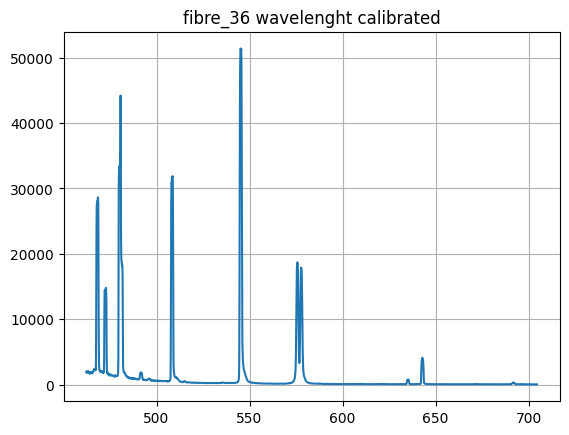

In [19]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelenght_calibrated, flat_calibrated)
frame.set_title(f"{location_of_maximum} wavelenght calibrated")
frame.grid()
show(fig)
close(fig)

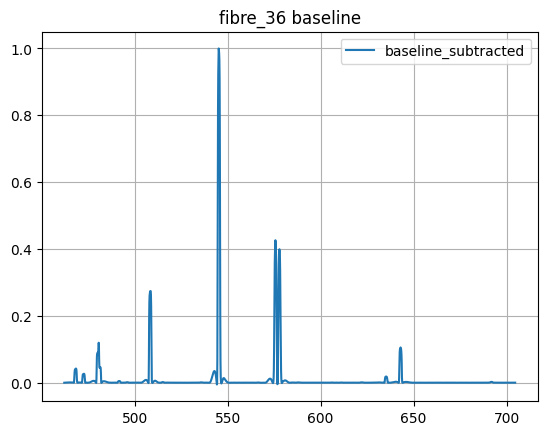

In [20]:
continuum_subtracted = spectrapepper.alsbaseline(horizontal_slice_dict_average[location_of_maximum], lam=10, remove=True)
# Do the same for the moon to look what is sky
# continuum_subtracted_moon = spectrapepper.alsbaseline(horizontal_slice_dict_average[location_of_maximum], lam=10, remove=True)

fig = figure()
frame = fig.add_subplot(1,1,1)
# frame.plot(horizontal_slice_dict_average[location_of_maximum], label = 'average')
frame.plot(wavelenght_calibrated, continuum_subtracted[::-1]/continuum_subtracted.max(), label = 'baseline_subtracted')
# frame.plot(wavelenght_calibrated, continuum_subtracted_moon[::-1]/continuum_subtracted_moon.max(), label = 'moon')

frame.set_title(f"{location_of_maximum} baseline")
frame.grid()
frame.legend()
show(fig)
close(fig)

In [21]:
# vega_calibration = np.loadtxt('Vega calibration.txt')
# 
# vega_calibration_wavelenght = []
# vega_calibration_values = []
# 
# size = int(vega_calibration.size/2)
# 
# for i in range(size):
#     vega_calibration_wavelenght.append(vega_calibration[i][0])
#     vega_calibration_values.append(vega_calibration[i][1])
# 
# 
# vega_calibration_wavelenght = np.array(vega_calibration_wavelenght)
# vega_calibration_values = np.array(vega_calibration_values)
# 
# # This wavelenght is in Angström while we have it in nm, so we convert
# vega_calibration_wavelenght /= 10
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(vega_calibration_wavelenght, vega_calibration_values)
# frame.set_title(f"Vega calibration data")
# frame.grid()
# show(fig)
# close(fig)

In [22]:
# # First we get the max and min values of our actual data
# minimum_wavelenght = wavelenght_calibrated[0]
# maximum_wavelenght = wavelenght_calibrated[-1]
# 
# horizontal_slice_dict[location_of_maximum] = horizontal_slice_dict[location_of_maximum][::-1]
# 
# # We crop the calibration data to our range
# mask1 = vega_calibration_wavelenght > minimum_wavelenght
# vega_calibration_wavelenght = vega_calibration_wavelenght[mask1]
# vega_calibration_values = vega_calibration_values[mask1]
# 
# mask2 = vega_calibration_wavelenght < maximum_wavelenght
# vega_calibration_wavelenght = vega_calibration_wavelenght[mask2]
# vega_calibration_values = vega_calibration_values[mask2]
# 
# # Then we interpolate the calibration data so it matches ours
# la = len(horizontal_slice_dict[location_of_maximum])
# interpolated_vega_calibration_values = np.interp(wavelenght_calibrated, vega_calibration_wavelenght, vega_calibration_values)
# 
# # Let's smooth both curves so we can find an accurate response curve
# # smooth_data = horizontal_slice_dict[location_of_maximum] - spectrapepper.alsbaseline(horizontal_slice_dict[location_of_maximum], lam=1000)
# # smooth_calibrated = interpolated_vega_calibration_values - spectrapepper.alsbaseline(interpolated_vega_calibration_values, lam=100000)
# # 
# # fig = figure()
# # frame = fig.add_subplot(1,1,1)
# # frame.plot(wavelenght_calibrated, smooth_data)
# # frame.plot(wavelenght_calibrated, smooth_calibrated)
# # frame.set_title(f"{location_of_maximum} responsecurve")
# # frame.grid()
# # show(fig)
# # close(fig)
# 
# # Now we can calculate the response curve and calibrate our data
# # Currently doesn't take into account the peaks
# response = flat_calibrated / interpolated_vega_calibration_values
# correction = 1/response
# smooth_correction = correction - spectrapepper.alsbaseline(correction, lam=1000)
# response_calibrated = flat_calibrated*correction
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelenght_calibrated, 1/response)
# frame.set_title(f"{location_of_maximum} responsecurve")
# frame.grid()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelenght_calibrated, horizontal_slice_dict[location_of_maximum])
# frame.set_title(f"{location_of_maximum} before response_calibrated")
# frame.grid()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelenght_calibrated, response_calibrated)
# frame.set_title(f"{location_of_maximum} response_calibrated")
# frame.grid()
# show(fig)
# close(fig)
# 
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelenght_calibrated, interpolated_vega_calibration_values)
# frame.set_title(f"{location_of_maximum} Calibration data")
# frame.grid()
# show(fig)
# close(fig)

In [23]:
# # Try a polyfit on calibration data
# y = np.poly1d(np.polyfit(wavelenght_calibrated, interpolated_vega_calibration_values, 1))
# d = np.polyval(y,wavelenght_calibrated)
# 
# response = horizontal_slice_dict[location_of_maximum] / d
# correction = 1/response
# response_calibrated = horizontal_slice_dict[location_of_maximum] * correction
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelenght_calibrated, response_calibrated)
# frame.set_title(f"{location_of_maximum} response_calibrated")
# frame.grid()
# show(fig)
# close(fig)

In [24]:
# # Let's try it on some galaxy data
# response_calibrated = flat_calibrated/response
# 
# 
# fig = figure()
# frame = fig.add_subplot(1, 1, 1)
# frame.plot(wavelenght_calibrated, response_calibrated)
# frame.set_title(f"{location_of_maximum} response calibrated")
# frame.grid()
# show(fig)
# close(fig)

In [62]:
np.savetxt('relative shifts.txt', shifts)
# np.savetxt('calibration.txt', horizontal_slice_dict_average[location_of_maximum])

ValueError: Expected 1D or 2D array, got 0D array instead